In [169]:
import astroprov
from astropy.io import fits
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

import numpy as np
from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad

import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table
from astropy.table import Column

import collections
import subprocess

In [175]:
imagedirectory = '/home/mj1e16/keplerImages'

newImagelist = []
Image = os.listdir(imagedirectory)
for i, item in enumerate(Image):
    if item.find('.fits') != -1:
        #print(i,Image[i].find('.fits'))
        newImagelist.append(item)
Image = newImagelist


FWHM = 5.0
MinSep = 0.8 #sets value for discriminating sources
N = len(Image) #number of images minus 1 as it starts from zero
imno = 0
imagedata = []
sources = dict()
Date = []
STD = []
Median = []


os.chdir(imagedirectory)
def daoStarFinder(imagename):
    """
    Locates and measures the brightness of all objects in the image as well as the sky background
    and other image data.

    :param imagenumber: Position of image in directory
    :return: Table of object data, date of observation, image data for backround calculation
    """
    #print(Image[imagenumber])
    hdu_list = fits.open(imagename) # open image header
    imagedata = (hdu_list[0].data) 
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
    Median.append(median)
    STD.append(std)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std) # iraf star finder 
    Sources = daofind(imagedata - median)
    #Date = (hdu_list[0].header['MJD'])
    output = {}
    output[0] = Sources
    output[1] = Date
    output[2] = imagedata
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (output[0]['xcentroid'], output[0]['ycentroid'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.savefig('fits.png',dpi=100)
    plt.show()
    
    
    
#     os.chdir(bindingsdirectory)
#     astroprov.provcall([imagenumber],[output[0],output[1],output[2]],"daoStarFinder_PythonCode2Images_SQ_tmpl.provn","daoStarFinder")
#     os.chdir(imagedirectory)
    return output




In [230]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)
#     # Convert the same coordinates back to pixel coordinates.
#     pixcrd2 = w.wcs_world2pix(world, 1)
#     print(pixcrd2)

#     # These should be the same as the original pixel coordinates, modulo
#     # some floating-point error.
#     assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6




In [208]:
def queryObjectRegion(outputTable,imageName,inCat):
    imageCoords = []
    r = 1*u.arcminute
    
    if inCat == 'dao':
        xlabel = 'xcentroid'
        ylabel = 'ycentroid'
        label = 'id'
        
    if inCat == 'sex':
        xlabel = 'X_IMAGE'
        ylabel = 'Y_IMAGE'
        label = 'NUMBER'
        
    tableLength = outputTable[label][-1]
    for x in range(tableLength):
        xpos = outputTable[xlabel][x]
        ypos = outputTable[ylabel][x]
        if 20 < ypos < 1040:
            if 12 < xpos < 1110:
                imageCoords.append([xpos,ypos])
                # this may need to change per image but I hope not

    coords = load_wcs_from_file(imageName,imageCoords)
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
    customSimbad.remove_votable_fields('coordinates')
            
    result_table = Table([['-'],[0],[0],['-'],[0],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))

    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            result_table.add_row(rowlist)

        except:
            result_table.add_row(['N/A',[0],[0],'Possible Transient',[imageCoords[x][0]],[imageCoords[x][1]]])
    
    hdu_list = fits.open(imageName)
    imagedata = (hdu_list[0].data) 
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (outputTable[xlabel], outputTable[ylabel])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    
    return result_table

In [193]:
def sextractor(sextractoryDir,imagename,cataloguename):
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imagename])
    assoc = Table.read(cataloguename,format='ascii.sextractor')

    os.chdir('/home/mj1e16/keplerImages/')
    hdu_list = fits.open(imagename[:-3]) # open image header
    imagedata = (hdu_list[0].data) 
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (assoc['X_IMAGE'], assoc['Y_IMAGE'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    return assoc

In [306]:
def findObjectOccurences(inputTable,columnName):
    otype = inputTable[columnName]
    otypelist = []
    for x in range(len(otype)):
        otypelist.append(otype[x])
    #print(len(otypelist))
    newotype = set(otypelist)
    counter = collections.Counter(otypelist)
    keys = counter.keys()
    values = counter.values()
    occurenceDict = dict(zip(keys,values))
    od = collections.OrderedDict(sorted(occurenceDict.items()))
    return od

In [295]:
def foundInBoth(daoTable,sexTable):
    
    # currently works after both have been checked through vizier - change sex x and y labels to X_IMAGE and Y_IMAGE otherwise
    simdifsize = 5
    
    daox = daoTable['xcentroid'].tolist()
    #daox = [round(x,1) for x in daox]
    daoy = daoTable['ycentroid'].tolist()
    #daoy = [round(x,1) for x in daoy]
    #daocoords = zip(daox,daoy)
    #print(daocoords)
    
    sexx = sexTable['xcentroid'].tolist()
    #sexx = [round(x,1) for x in sexx]
    sexy = sexTable['ycentroid'].tolist()
    #sexy = [round(x,1) for x in sexy]

    commonIndicies = [[x,y] for x,y,z,v in zip(daox,daoy,sexx,sexy) if z-simdifsize < x < z+simdifsize and v-simdifsize < y < v+simdifsize]
    
    return commonIndicies

In [296]:
commonObjects = foundInBoth(result_table_dao,result_table_sex)

In [297]:
commonObjects

[[0.0, 0.0], [964.7147814396362, 909.8924717438197]]

In [185]:
imageName = 'difkplr2009115080620_ffi-cal57.fits[0]'

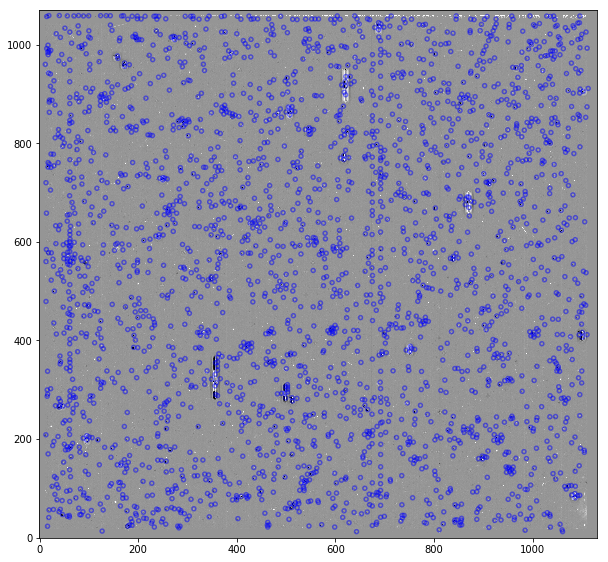

In [195]:
sextable = sextractor('/home/mj1e16/sextractor/sextractor-master/config/','difkplr2009115080620_ffi-cal57.fits[0]','test.cat')

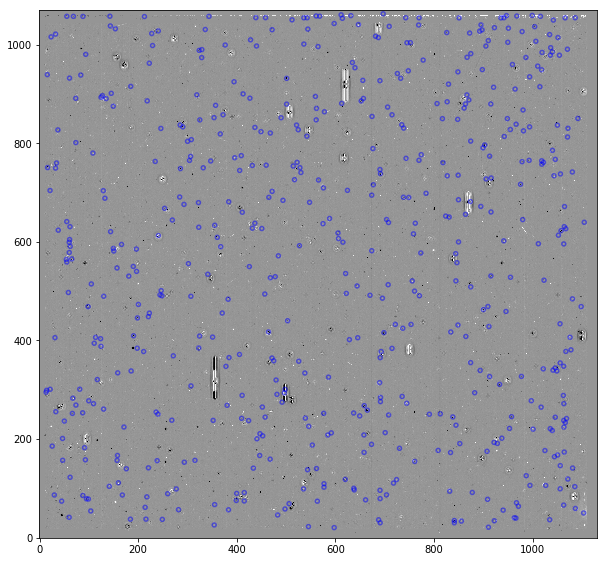

In [299]:
output = daoStarFinder('difkplr2009115080620_ffi-cal57.fits')
daotable = output[0]
Date = output[1]
imagedata = output[2]

In [45]:
coords = load_wcs_from_file(dirlist[1],imageCoords)


[[293.46444504  47.82481195]
 [293.28200172  47.93244896]
 [293.49045387  48.06138588]
 [293.48240163  48.06741086]
 [293.10025218  48.06202995]
 [293.43096403  48.1969272 ]
 [292.77537915  47.99003348]
 [293.58269837  48.50906246]
 [292.41557497  48.0496506 ]
 [292.6234505   48.21179312]
 [293.4021616   48.61239655]
 [293.78766422  48.76700135]
 [292.93563809  48.66217611]]


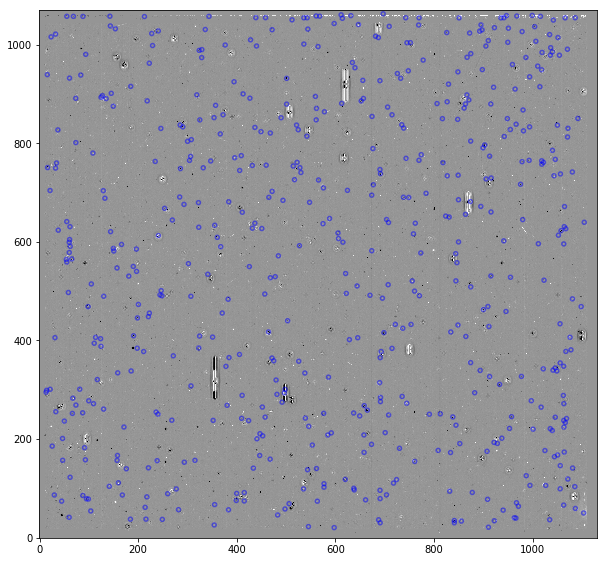

In [240]:
result_table_dao = queryObjectRegion(daotable,dirlist[1],'dao')

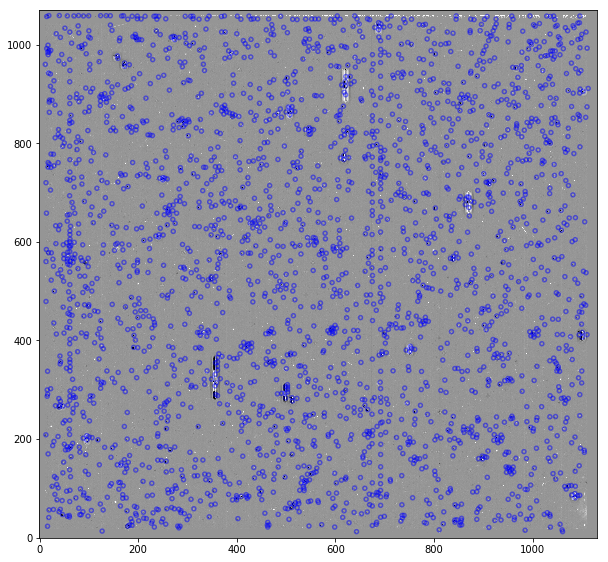

In [313]:
result_table_sex = queryObjectRegion(sextable,dirlist[1],'sex')

In [301]:
#commonObjects = foundInBoth(result_table_dao,result_table_sex)

In [314]:
otypes = findObjectOccurences(result_table_sex,'OTYPE')
#otypyes 
print('Sex',otypes)
otypes = findObjectOccurences(result_table_dao,'OTYPE')
print('dao',otypes)

('Sex', OrderedDict([('-', 1), ('Cepheid', 4), ('EB*', 15), ('EB*Algol', 6), ('EB*WUMa', 1), ('EB*betLyr', 1), ('EllipVar', 2), ('Eruptive*', 38), ('Galaxy', 18), ('HotSubdwarf', 1), ('IR>30um', 4), ('Inexistent', 2), ('LPV*', 5), ('Mira', 6), ('PM*', 28), ('Planet', 2), ('Planet?', 7), ('Possible Transient', 431), ('PulsV*delSct', 12), ('RGB*', 135), ('Radio', 5), ('RotV*', 284), ('Star', 1478), ('V*', 4), ('WD*', 1), ('X', 1), ('gammaDor', 1), ('low-mass*', 1)]))
('dao', OrderedDict([('-', 1), ('EB*', 2), ('EB*Algol', 1), ('EB*WUMa', 1), ('Eruptive*', 6), ('Galaxy', 2), ('HotSubdwarf', 1), ('LPV*', 1), ('Mira', 1), ('PM*', 3), ('Planet?', 2), ('Possible Transient', 74), ('RGB*', 27), ('RotV*', 65), ('Star', 340), ('V*', 2), ('gammaDor', 1)]))


In [315]:
mask = (result_table_sex['OTYPE']=='Inexistent')
print(result_table_sex[mask])

  MAIN_ID     RA_d    DEC_d    OTYPE    xcentroid ycentroid
----------- -------- ------- ---------- --------- ---------
KOI-3449.01 292.5204 48.1236 Inexistent  968.5644   645.594
KOI-3449.01 292.5204 48.1236 Inexistent   956.296  639.9041
